<a href="https://colab.research.google.com/github/Sorrakit-Bank100/CNN_DeepLearning_Project/blob/main/Chest_X_Ray_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/sachinkumar413/covid-pneumonia-normal-chest-xray-images/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: SorakitBank
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sachinkumar413/covid-pneumonia-normal-chest-xray-images


100%|██████████| 277M/277M [00:00<00:00, 960MB/s] 

In [ ]:
import torch
from torch import nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os
from torchvision import models

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device available: ", device)

Device available:  cuda


In [ ]:
image_path = []
labels = []

base_dir = "/content/covid-pneumonia-normal-chest-xray-images"

for class_name in os.listdir(base_dir):
  class_path = os.path.join(base_dir, class_name)
  for image_name in os.listdir(class_path):
    image_path.append(os.path.join(class_path, image_name))
    labels.append(class_name)

data_df = pd.DataFrame(zip(image_path, labels), columns = ['image_paths', 'labels'])
data_df.head()

,image_paths,labels
0,/content/covid-pneumonia-normal-chest-xray-ima...,COVID
1,/content/covid-pneumonia-normal-chest-xray-ima...,COVID
2,/content/covid-pneumonia-normal-chest-xray-ima...,COVID
3,/content/covid-pneumonia-normal-chest-xray-ima...,COVID
4,/content/covid-pneumonia-normal-chest-xray-ima...,COVID


In [ ]:
# Data Split
train=data_df.sample(frac=0.7,random_state=13)
test=data_df.drop(train.index)
val=test.sample(frac=0.5,random_state=13)
test=test.drop(val.index)

In [ ]:
print(data_df['labels'].value_counts())

labels
NORMAL       1802
PNEUMONIA    1800
COVID        1626
Name: count, dtype: int64


In [ ]:
print(data_df.shape)

(5228, 2)


In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df['labels'])

LabelEncoder()

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05)
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    transforms.ConvertImageDtype(torch.float)
    ])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
     transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    transforms.ConvertImageDtype(torch.float)])

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
          image = self.transform(image).to(device)

        return image, label

In [ ]:
train_dataset = CustomImageDataset(dataframe=train, transform=train_transform)
val_dataset = CustomImageDataset(dataframe=val, transform=train_transform)
test_dataset = CustomImageDataset(dataframe=test, transform=test_transform)

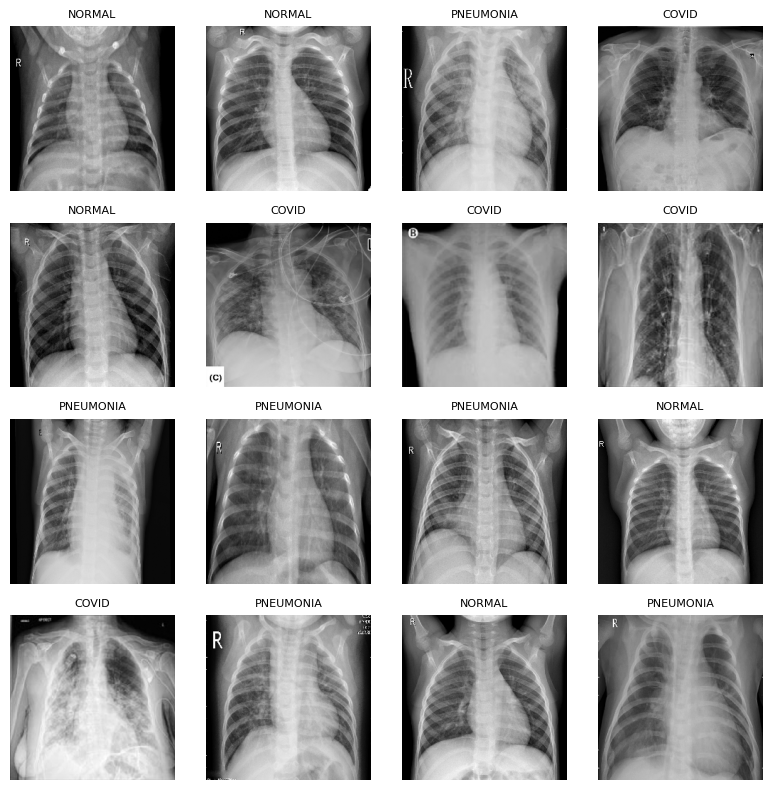

In [ ]:
n_rows = 4
n_cols = 4
f, axarr = plt.subplots(n_rows, n_cols, figsize=(8, 8))

for row in range(n_rows):
    for col in range(n_cols):
        sample = data_df.sample(n=1).iloc[0]
        image = Image.open(sample['image_paths']).convert("L")

        label = sample['labels']

        axarr[row, col].imshow(image, cmap='grey')# jet turbo
        axarr[row, col].set_title(f"{label}", fontsize=8)
        axarr[row, col].axis('off')

plt.tight_layout()
plt.show()

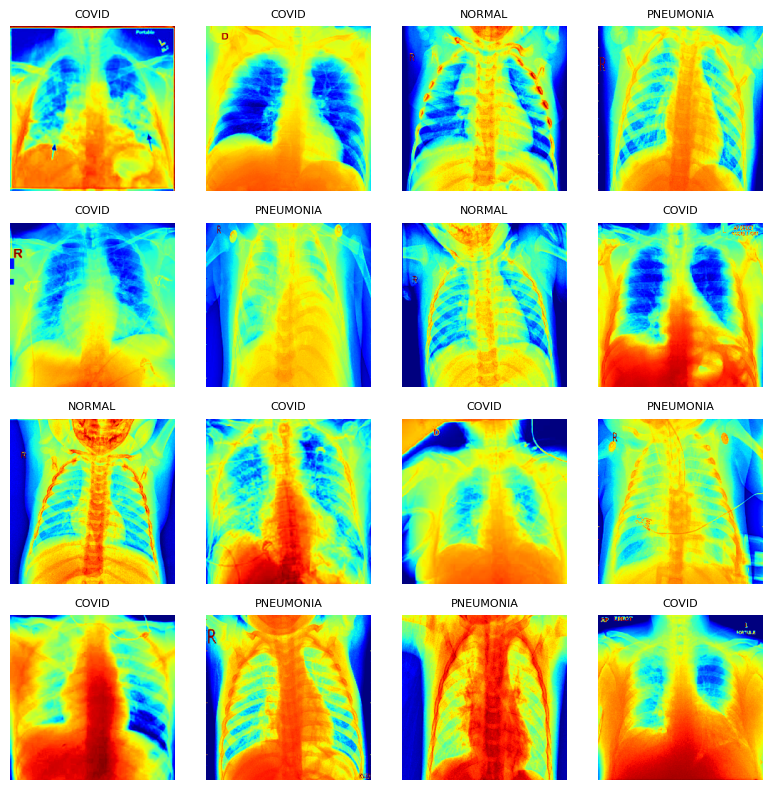

In [ ]:
n_rows = 4
n_cols = 4
f, axarr = plt.subplots(n_rows, n_cols, figsize=(8, 8))

for row in range(n_rows):
    for col in range(n_cols):
        sample = data_df.sample(n=1).iloc[0]
        image = Image.open(sample['image_paths']).convert("L")

        label = sample['labels']

        axarr[row, col].imshow(image, cmap='jet')# jet turbo
        axarr[row, col].set_title(f"{label}", fontsize=8)
        axarr[row, col].axis('off')

plt.tight_layout()
plt.show()

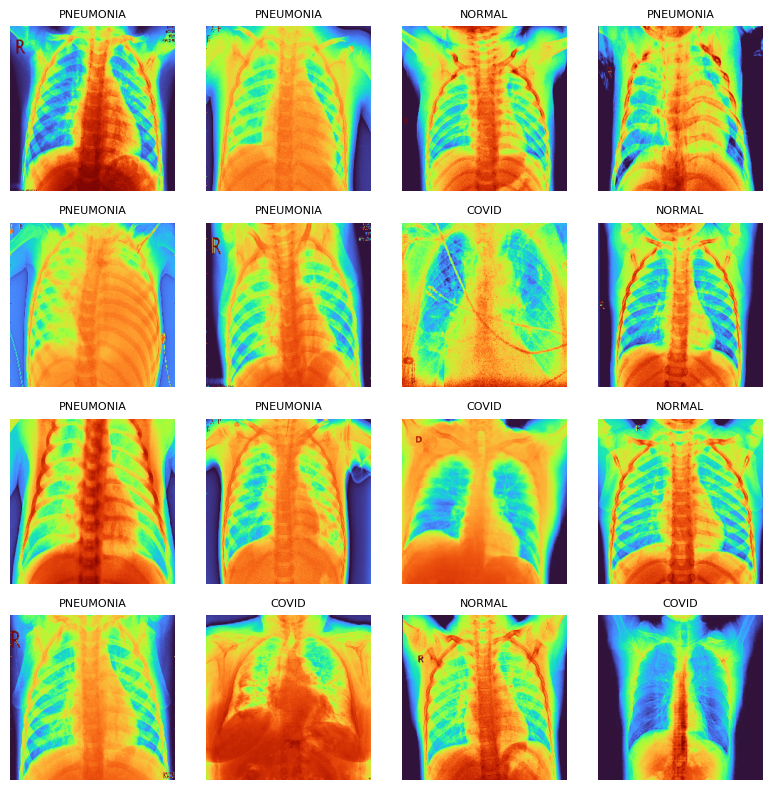

In [ ]:
n_rows = 4
n_cols = 4
f, axarr = plt.subplots(n_rows, n_cols, figsize=(8, 8))

for row in range(n_rows):
    for col in range(n_cols):
        sample = data_df.sample(n=1).iloc[0]
        image = Image.open(sample['image_paths']).convert("L")

        label = sample['labels']

        axarr[row, col].imshow(image, cmap='turbo')
        axarr[row, col].set_title(f"{label}", fontsize=8)
        axarr[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 25
num_classes = len(data_df['labels'].unique())

In [ ]:
# create objects of it to simplify the training by DataLoader from torch
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
googlenet_model = models.googlenet(pretrained=True,)
for param in googlenet_model.parameters():
  param.requires_grad = False

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 80.5MB/s]


In [ ]:
googlenet_model = googlenet_model.to(device)

In [ ]:
print(googlenet_model)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
googlenet_model.fc = nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.fc.to(device)


Linear(in_features=1024, out_features=3, bias=True)

In [ ]:

for param in googlenet_model.inception5a.parameters():
  param.requires_grad = True
for param in googlenet_model.inception5b.parameters():
  param.requires_grad = True
for param in googlenet_model.fc.parameters():
  param.requires_grad = True

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(), lr=LR)

In [ ]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), correct / total

In [ ]:
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(loader), correct / total

In [ ]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(googlenet_model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(googlenet_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
    print("="*25)


Epoch 1/25
Train Loss: 0.3509 | Train Acc: 0.8814
Val   Loss: 0.1681 | Val   Acc: 0.9439
Epoch 2/25
Train Loss: 0.1773 | Train Acc: 0.9388
Val   Loss: 0.1378 | Val   Acc: 0.9554
Epoch 3/25
Train Loss: 0.1449 | Train Acc: 0.9497
Val   Loss: 0.1073 | Val   Acc: 0.9681
Epoch 4/25
Train Loss: 0.1241 | Train Acc: 0.9544
Val   Loss: 0.1050 | Val   Acc: 0.9694
Epoch 5/25
Train Loss: 0.1234 | Train Acc: 0.9555
Val   Loss: 0.0778 | Val   Acc: 0.9796
Epoch 6/25
Train Loss: 0.1057 | Train Acc: 0.9615
Val   Loss: 0.1044 | Val   Acc: 0.9668
Epoch 7/25
Train Loss: 0.0959 | Train Acc: 0.9672
Val   Loss: 0.0820 | Val   Acc: 0.9694
Epoch 8/25
Train Loss: 0.0845 | Train Acc: 0.9697
Val   Loss: 0.0831 | Val   Acc: 0.9694
Epoch 9/25
Train Loss: 0.0866 | Train Acc: 0.9680
Val   Loss: 0.0759 | Val   Acc: 0.9707
Epoch 10/25
Train Loss: 0.0813 | Train Acc: 0.9749
Val   Loss: 0.0677 | Val   Acc: 0.9796
Epoch 11/25
Train Loss: 0.0729 | Train Acc: 0.9746
Val   Loss: 0.0738 | Val   Acc: 0.9796
Epoch 12/25
Train L

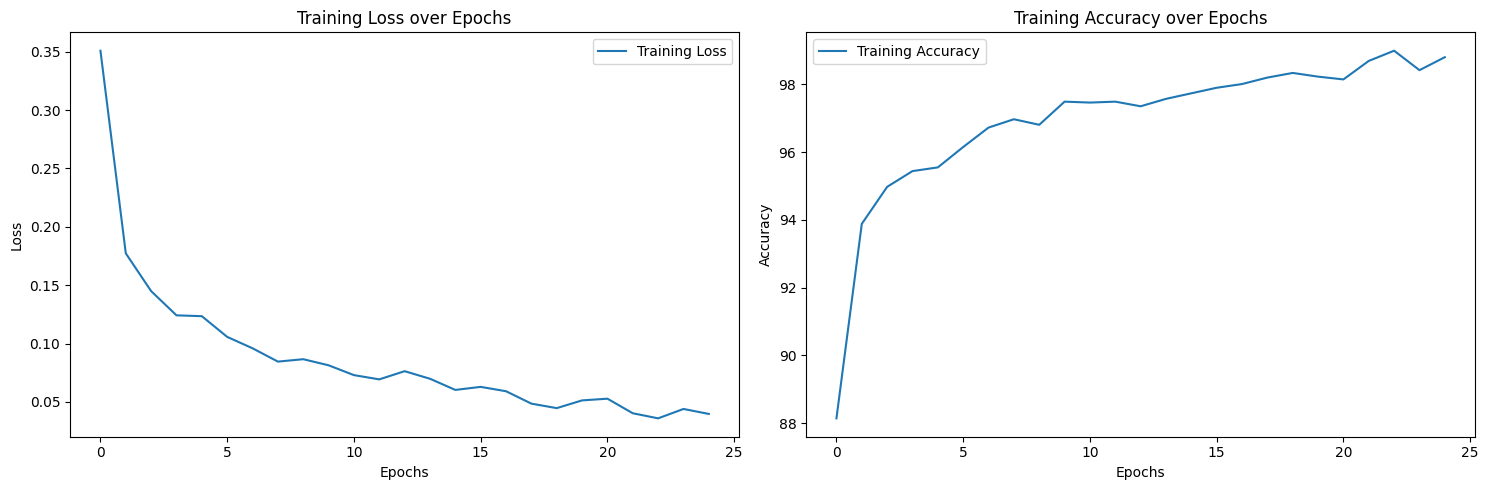

In [ ]:
#Plot
train_accs = np.array(train_accs) * 100
train_losses = np.array(train_losses)
val_accs = np.array(val_accs) * 100
val_losses = np.array(val_losses)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot Training Loss
axs[0].plot(train_losses, label='Training Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot Training Accuracy
axs[1].plot(train_accs, label='Training Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

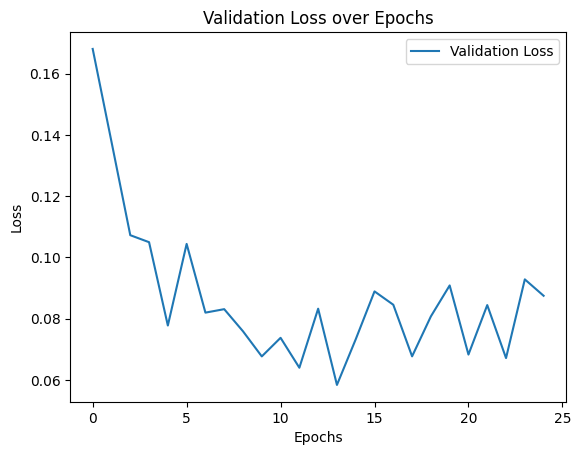

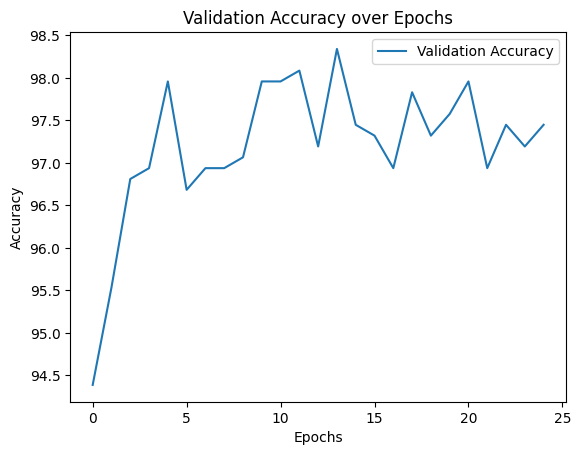

In [ ]:
plt.plot(val_losses, label='Validation Loss')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot val_acc

plt.plot(val_accs, label='Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Test
test_predictions = []
test_labels = []
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(test_loader):

    prediction = googlenet_model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    test_predictions.append(torch.argmax(prediction, axis = 1))
    test_labels.append(labels)
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())*100, 2)}%")



Accuracy Score is: 98.09%


In [ ]:
# f1 score ,precision , recall
from sklearn.metrics import f1_score, precision_score, recall_score

y_true = torch.cat(test_labels).cpu().numpy()
y_pred = torch.cat(test_predictions).cpu().numpy()

f1 = f1_score(y_true, y_pred, average='macro')

precision = precision_score(y_true, y_pred, average='macro')

recall = recall_score(y_true, y_true, average='macro')

print(f"F1 Score: {f1:.4f}")
print(f"Precision Score: {precision:.4f}")
print(f"Recall Score: {recall:.4f}")

F1 Score: 0.9816
Precision Score: 0.9818
Recall Score: 1.0000


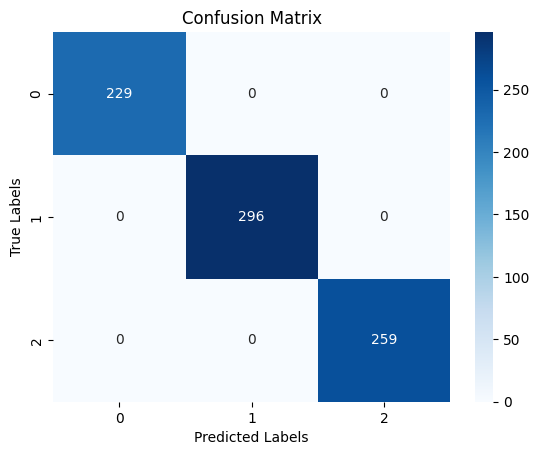

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_true)
# plot confusin matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
def predict_class(image_path):
  image = Image.open(image_path).convert('RGB')
  image = test_transform(image).to(device)
  image = image.unsqueeze(0) # add one dimension->CNN expect batch input
  with torch.no_grad():
    prediction = googlenet_model(image)
    prediction = torch.argmax(prediction, axis = 1).item()
  return label_encoder.inverse_transform([prediction])





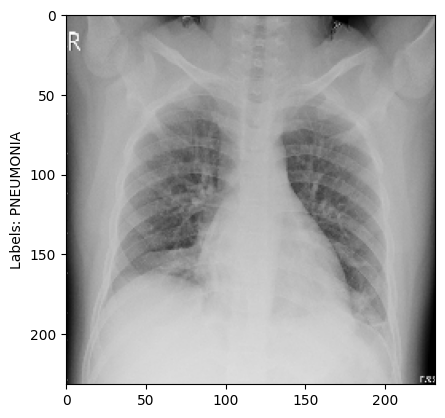

In [ ]:
test_image = Image.open('/content/covid-pneumonia-normal-chest-xray-images/PNEUMONIA/PNEUMONIA_1019.png').convert('RGB')


plt.imshow(test_image)
plt.ylabel("Labels: PNEUMONIA")
plt.show()

In [ ]:

print(f'Predict from model :{predict_class('/content/covid-pneumonia-normal-chest-xray-images/PNEUMONIA/PNEUMONIA_1019.png')}')


Predict from model :['PNEUMONIA']


# Resnet Model

In [ ]:
resnet_model = models.resnet50(pretrained=True)
resnet_model = resnet_model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 194MB/s]


In [ ]:
# Replace Final Layer
in_features = resnet_model .fc.in_features
resnet_model.fc = nn.Linear(in_features, num_classes).to(device)

In [ ]:
for param in resnet_model.parameters():
  param.requires_grad = False

In [ ]:
for param in resnet_model.layer4.parameters():
    param.requires_grad = True

for param in resnet_model.fc.parameters():
    param.requires_grad = True

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    [
    {'params': resnet_model.layer4.parameters(), 'lr': 1e-4},
    {'params': resnet_model.fc.parameters(), 'lr': 1e-3},]
)

In [ ]:
epochs = 30
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(resnet_model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(resnet_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
    print("="*25)


Epoch 1/25
Train Loss: 0.2512 | Train Acc: 0.9112
Val   Loss: 0.1009 | Val   Acc: 0.9681
Epoch 2/25
Train Loss: 0.1480 | Train Acc: 0.9527
Val   Loss: 0.0841 | Val   Acc: 0.9719
Epoch 3/25
Train Loss: 0.1128 | Train Acc: 0.9590
Val   Loss: 0.0830 | Val   Acc: 0.9758
Epoch 4/25
Train Loss: 0.1031 | Train Acc: 0.9678
Val   Loss: 0.0720 | Val   Acc: 0.9770
Epoch 5/25
Train Loss: 0.0758 | Train Acc: 0.9765
Val   Loss: 0.0669 | Val   Acc: 0.9770
Epoch 6/25
Train Loss: 0.0764 | Train Acc: 0.9760
Val   Loss: 0.0597 | Val   Acc: 0.9809
Epoch 7/25
Train Loss: 0.0790 | Train Acc: 0.9773
Val   Loss: 0.1082 | Val   Acc: 0.9656
Epoch 8/25
Train Loss: 0.0661 | Train Acc: 0.9784
Val   Loss: 0.0736 | Val   Acc: 0.9732
Epoch 9/25
Train Loss: 0.0515 | Train Acc: 0.9822
Val   Loss: 0.0599 | Val   Acc: 0.9796
Epoch 10/25
Train Loss: 0.0526 | Train Acc: 0.9809
Val   Loss: 0.0406 | Val   Acc: 0.9860
Epoch 11/25
Train Loss: 0.0383 | Train Acc: 0.9850
Val   Loss: 0.0764 | Val   Acc: 0.9783
Epoch 12/25
Train L

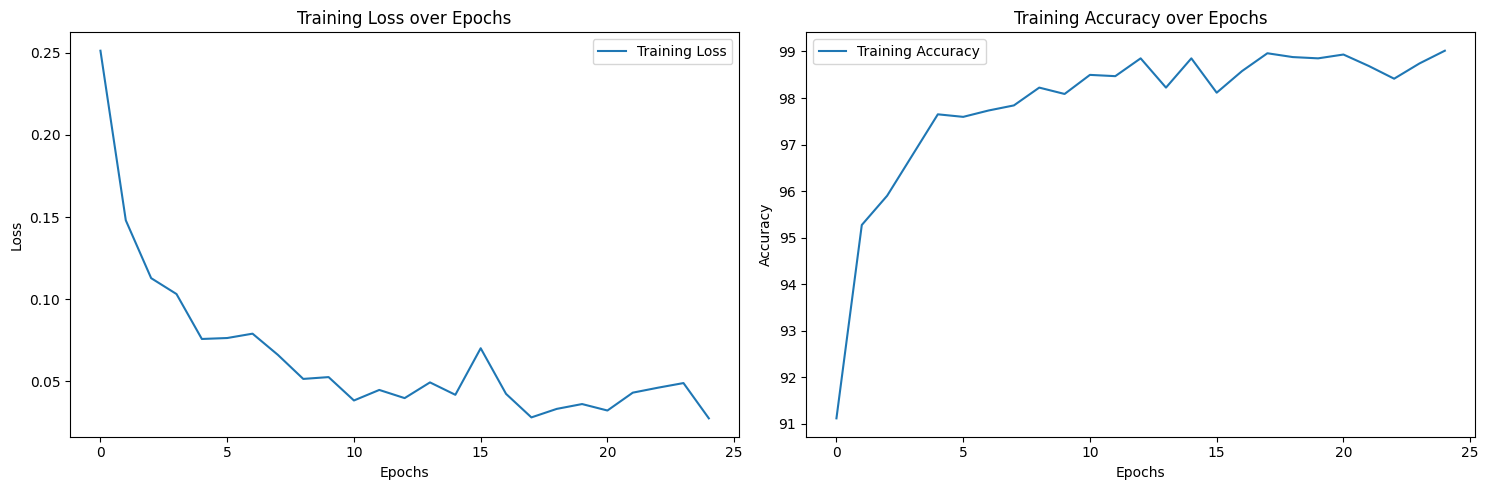

In [ ]:
#Plot
train_accs = np.array(train_accs) * 100
train_losses = np.array(train_losses)
val_accs = np.array(val_accs) * 100
val_losses = np.array(val_losses)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot Training Loss
axs[0].plot(train_losses, label='Training Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot Training Accuracy
axs[1].plot(train_accs, label='Training Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

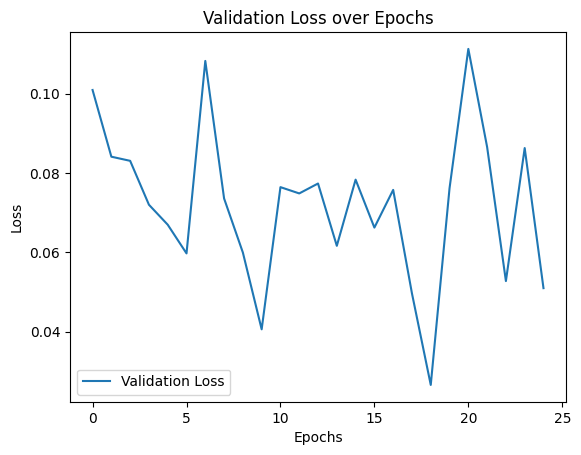

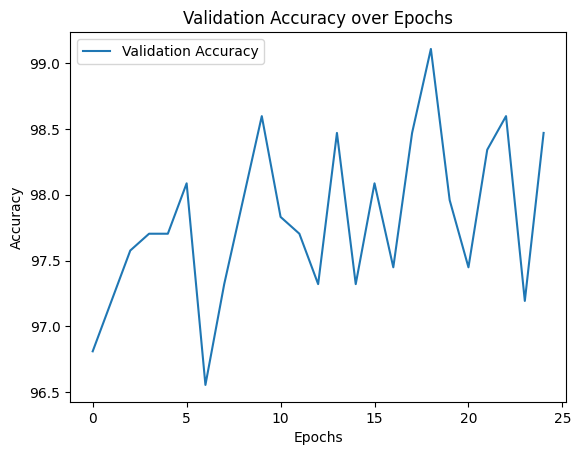

In [ ]:
plt.plot(val_losses, label='Validation Loss')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot val_acc

plt.plot(val_accs, label='Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Test
test_predictions = []
test_labels = []
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, (input, labels) in enumerate(test_loader):

    prediction = resnet_model(input)

    acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
    test_predictions.append(torch.argmax(prediction, axis = 1))
    test_labels.append(labels)
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())*100, 2)}%")


Accuracy Score is: 97.7%


In [ ]:
# f1 score ,precision , recall
from sklearn.metrics import f1_score, precision_score, recall_score

y_true = torch.cat(test_labels).cpu().numpy()
y_pred = torch.cat(test_predictions).cpu().numpy()

f1 = f1_score(y_true, y_pred, average='macro')

precision = precision_score(y_true, y_pred, average='macro')

recall = recall_score(y_true, y_true, average='macro')

print(f"F1 Score: {f1:.4f}")
print(f"Precision Score: {precision:.4f}")
print(f"Recall Score: {recall:.4f}")

F1 Score: 0.9780
Precision Score: 0.9795
Recall Score: 1.0000


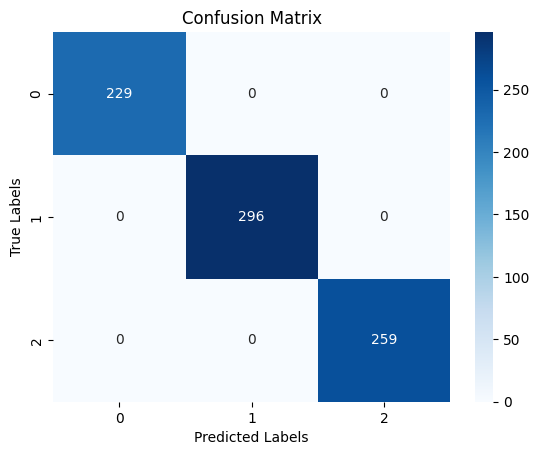

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_true)
# plot confusin matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()